# BEE 4750: Final Project

Members: Jonathan Marcuse (jrm564), Geovany Rodriguez (ga283), Oliver Sandiford (ots22)

In [46]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/Final Projects/4750_Project`


In [47]:
#initiating several packages that may be useful later
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("Distributions")
using Plots
using CSV
using DataFrames
using Dates
using Distributions

   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/Final Projects/4750_Project/Project.toml`
  No Changes to `~/Desktop/Final Projects/4750_Project/Manifest.toml`


#### Implementing the first component of the model - Determining how many aircrafts can land per hour

In [48]:
#Initialize flexible variables
aircraft_landing_speeds = [130 137.5 145 152.5 160]; #landing speeds of each type of aircraft in knots (interpolated)
proportions = [0.101333333 0.248 0.242666667 0.370666667 0.037333333]; #proportion of each type of aircraft, corresponding to the number of ones listed above
delta = 3; #minimum spacing between aircrafts in nautical miles (safety parameter) - taken from CEE 4640 safety parameter
gamma = [(10000/6076.11549) (6800/6076.11549) (11000/6076.11549)]; #length of the runway in nautical miles for each runway
#converted length in ft to nautical miles with 6,076.11549 ft per nautical mile
#The first 2 runways are for landing only and the third is for takeoff only

1×3 Matrix{Float64}:
 1.64579  1.11914  1.81037

In [49]:
for k in 1:2
    l = length(aircraft_landing_speeds);
    Time_Space = zeros(l,l);
    Time_Probabilities = zeros(l,l);
    for i in 1:l
        for j in 1:l
            Time_Space[i,j] = aircraft_landing_speeds[i] > aircraft_landing_speeds[j] ? ((delta/aircraft_landing_speeds[i])*3600) : (((delta/aircraft_landing_speeds[i])+(gamma[k]/aircraft_landing_speeds[i])-(gamma[k]/aircraft_landing_speeds[j]))*3600)
            Time_Probabilities[i,j] = proportions[i]*proportions[j]*Time_Space[i,j];
        end
    end
    avg_time = sum(Time_Probabilities); #total average seconds between aircraft landings
    aircrafts_per_hour = floor((1/avg_time)*3600); #floor functin used because you cant have a fraction of an aircraft land
    println("The average amount of time in between aircraft landings each hour on runway $k is $avg_time seconds")
    println("The total number of aircrafts that can land per hour on average on runway $k is $aircrafts_per_hour aircrafts/hour")
    println(" ")
end
k=3
l = length(aircraft_landing_speeds);
Time_Space = zeros(l,l);
Time_Probabilities = zeros(l,l);
for i in 1:l
    for j in 1:l
        Time_Space[i,j] = aircraft_landing_speeds[i] > aircraft_landing_speeds[j] ? ((delta/aircraft_landing_speeds[i])*3600) : (((delta/aircraft_landing_speeds[i])+(gamma[k]/aircraft_landing_speeds[i])-(gamma[k]/aircraft_landing_speeds[j]))*3600)
        Time_Probabilities[i,j] = proportions[i]*proportions[j]*Time_Space[i,j];
    end
end
avg_time = sum(Time_Probabilities); #total average seconds between aircraft landings
aircrafts_per_hour = floor((1/avg_time)*3600); #floor functin used because you cant have a fraction of an aircraft land
println("The average amount of time in between aircraft takeoffs each hour on runway $k is $avg_time seconds")
println("The total number of aircrafts that can take off per hour on average on runway $k is $aircrafts_per_hour aircrafts/hour")


The average amount of time in between aircraft landings each hour on runway 1 is 76.02652327219118 seconds
The total number of aircrafts that can land per hour on average on runway 1 is 47.0 aircrafts/hour
 
The average amount of time in between aircraft landings each hour on runway 2 is 75.61570264937018 seconds
The total number of aircrafts that can land per hour on average on runway 2 is 47.0 aircrafts/hour
 
The average amount of time in between aircraft takeoffs each hour on runway 3 is 76.15490471682274 seconds
The total number of aircrafts that can take off per hour on average on runway 3 is 47.0 aircrafts/hour


The first matrix above is the needed spacing between aircrafts landing in seconds, where the first row and first column are the speed of the first aircraft listed in the aircraft_landing_speeds vector. The second matrix above is the proportion of each type of aircraft multiplied by each other and then by the time spacing to form the time probability matrix that will later be used to find the total average time between aircrafts by summing all of its elements.

---

- historical runway usage --> flight demand data
- weather conditions --> what weather conditions cause flight to be cancelled
- Air traffic volume & air wake concerns--> model already built out
- passenger load and unload time

Average number of days per month with wind speeds above 38mph:
January had 1.7 days above 38mph, 1.7 feb, 1.6 days in march, 0.2 april, 0 may, 0 june, 0 july, 0 august, 0 sept, 0.1 oct, 0.4 nov, 1.9 dec

---

### Create A Distribution of All Planes

In [50]:
#value is the speed of the selected aircraft as this is what is relevance for wake calculations
aircraft_landing_speeds = [130, 137.5, 145, 152.5, 160]; 
proportions = [0.101333333, 0.248, 0.242666667, 0.370666667, 0.037333333]; #proportions of each
plane_dist = Categorical(proportions);
#Creating the distribution to select planes from 
#plane_distribution = Weighted(aircraft_landing_speeds, proportions);


### for iteration codeblock
#selected_plane = rand(plane_distribution);

Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.101333333, 0.248, 0.242666667, 0.370666667, 0.037333333]
)


### Create function to find separation time between two types of aircrafts

In [51]:
function wake_time(plane1_speed,plane2_speed,min_spacing,runway_length)
    Time_Space = plane1_speed > plane2_speed ? 
    ((min_spacing/plane1_speed)*3600) : 
    (((min_spacing/plane1_speed)+(runway_length/plane1_speed)
    -(runway_length/plane2_speed))*3600);
    return Time_Space
end

wake_time (generic function with 1 method)

---

### Monte Carlo Iteration of EWR Air Traffic Model

In [52]:
days = zeros(5000);
#Monte Carlo loop
for j in 1:5000

    tot_planes_per_week = 8621; #planes per week
    min_spacing = 3; #nautical miles (safety parameter for distance between aircrafts in air)
    runway1_length = (10000/6076.11549); #nautical miles for runway 1
    runway2_length = (11000/6076.11549); #nautical miles for runway 2
    t = zeros(Float64, 2); #initial time at beginning of iteration where position 2 a tracker for time related to arrivals and position 1 is related to departures
    i=1; #initialize iteration stepper

    full_gates = 72; #60% of 121 gates full initially and this can never go above 121
    plane = zeros(tot_planes_per_week); #initialize
    selected_plane = rand(plane_dist);
    plane[i] = aircraft_landing_speeds[selected_plane] #select the first for comparison to the next in the for loop

    while full_gates <=121 && i<=tot_planes_per_week-1 #loop fails if gate capacity fills and terminates if all planes land and depart
        i = i+1 #iterate plane number of the week
        selected_plane = rand(plane_dist); #randomly select an index 1 through 5 based on weighted distribution
        plane[i] = aircraft_landing_speeds[selected_plane]; #use the randomly chosen index to get the associated plane landing/takeoff speed

        landing_wake_time_separation = (wake_time(plane[i],plane[i-1],min_spacing,runway1_length))/2; #divided by 2 to assume two runways used
        t[2] = t[2]+landing_wake_time_separation; #time step of wake separation times
        full_gates = full_gates+1; #one new plane at the gate

        #time delays after landing
        deplane_and_boarding = 90*60+120; #90 minutes per plane to board and deplane and 2 min for taxi
        takeoff_wake_time_separation = wake_time(plane[i-1],plane[i],min_spacing,runway1_length); #reversed planes and not divided by 2 to make sure every landing plane also takes off, but at half the separation time
        time_for_departure = max(takeoff_wake_time_separation,deplane_and_boarding/full_gates); #amount of time for each gate to be ready to fly another plane
        
        if t[2]-t[1]>=time_for_departure #situation where a departure has occured since the last arrival
            departures = floor((t[2]-t[1])/time_for_departure); #number of departures that could've occured in this delta t
            full_gates = full_gates-departures; #subtract number of full gates
            t[1] = t[1]+time_for_departure*departures; #additional time iteration for departures
        elseif t[2]-t[1]<time_for_departure && full_gates==121 #situation where no departure since last arrival and gates are all full
            t[2] = t[1]+time_for_departure; #time step increase to have arrivals delayed until gate space is open
            full_gates = full_gates-1;
        end
    end

    days[j] = t[2]/86400;
end

println("It will take $(round(sum(days)/length(days),digits=4)) days for all 8621 planes to land and departure
compared to the 7 days for 8621 planes to land under normal opertations")

It will take 4.5785 days for all 8621 planes to land and departure
compared to the 7 days for 8621 planes to land under normal opertations


Assumptions made in the above:
- starting gate capacity will be 72 out of 121, but for the majority of the rest of the week it will run at full capacity (can constrain lower if needed)
- total time between takeoffs will be the wake time separation between aircrafts OR the waiting time for deplane, boarding and taxi divided by the total number of gates which gives you the total time in between filled gates with planes ready to depart: whichever of these 2 is greatest will be used
- total time between landings will be the wake separation equation because it also includes length of the runway parameter to ensure it is cleared before the next landing
- Not really an assumption but an added explanation to the above code: The takeoffs and landings must be coordinated such that the total number of grounded planes filling gates is not exceeded which is why we have the if statements for additional time steps


Still need to:
- Add delays from weather
- Get something to be graphed
- Total people transported in alloted timeframe
- Associated Emissions? Needs some environmental aspect

In [53]:
days = zeros(5000);
#Monte Carlo loop
for j in 1:5000

    tot_planes_per_week = 8621; #planes per week
    min_spacing = 3; #nautical miles (safety parameter for distance between aircrafts in air)
    runway1_length = (10000/6076.11549); #nautical miles for runway 1
    runway2_length = (6800/6076.11549); #nautical miles for runway 2
    runway3_length = (11000/6076.11549); #nautical miles for runway 3
    t = zeros(Float64, 3); #initial time at beginning of iteration where position 1 is a tracker of time related to runway 1, position 2 for arrivals on runway 2 and position 3 for departures in runway 3
    i=1; #initialize iteration stepper

    full_gates = 72; #60% of 121 gates full initially and this can never go above 121
    plane = zeros(tot_planes_per_week); #initialize
    selected_plane = rand(plane_dist);
    plane[i] = aircraft_landing_speeds[selected_plane] #select the first for comparison to the next in the for loop
    #first plane lands at time t=0

    while full_gates <=121 && i<=tot_planes_per_week-1 #loop fails if gate capacity fills and terminates if all planes land and depart
        i = i+1 #iterate plane number of the week
        selected_plane = rand(plane_dist); #randomly select an index 1 through 5 based on weighted distribution
        plane[i] = aircraft_landing_speeds[selected_plane]; #use the randomly chosen index to get the associated plane landing/takeoff speed

        if t[1]<=t[2]
            landing_wake_time_separation = (wake_time(plane[i],plane[i-1],min_spacing,runway1_length)); #wake time separation on runway 1
            t[1] = t[1]+landing_wake_time_separation; #time step of wake separation times
            full_gates = full_gates+1; #one new plane at the gate
            chosen_runway = 1;
        else
            landing_wake_time_separation = (wake_time(plane[i],plane[i-1],min_spacing,runway2_length)); #wake time separation on runway 2
            t[2] = t[2]+landing_wake_time_separation; #time step of wake separation times
            full_gates = full_gates+1; #one new plane at the gate
            chosen_runway = 2;
        end

        #time delays after landing
        deplane_and_boarding = 90*60+120; #90 minutes per plane to board and deplane and 2 min for taxi
        takeoff_wake_time_separation = wake_time(plane[i-1],plane[i],min_spacing,runway1_length); #reversed planes and not divided by 2 to make sure every landing plane also takes off, but at half the separation time
        time_for_departure = max(takeoff_wake_time_separation,deplane_and_boarding/full_gates); #amount of time for each gate to be ready to fly another plane
        
        if chosen_runway == 1
            if t[1]-t[3]>=time_for_departure #situation where a departure has occured since the last arrival
                departures = floor((t[1]-t[3])/time_for_departure);
                full_gates = full_gates-departures; #subtract number of full gates
                t[3] = t[3]+time_for_departure*departures; #additional time iteration for departures
            elseif t[1]-t[3]<time_for_departure && full_gates==121 #situation where no departure since last arrival and gates are all full
                t[1] = t[3]+time_for_departure; #time step increase to have arrivals delayed until gate space is open
                full_gates = full_gates-1;
            end
        elseif chosen_runway == 2
            if t[2]-t[3]>=time_for_departure #situation where a departure has occured since the last arrival
                departures = floor((t[2]-t[3])/time_for_departure);
                full_gates = full_gates-departures; #subtract number of full gates
                t[3] = t[3]+time_for_departure*departures; #additional time iteration for departures
            elseif t[2]-t[3]<time_for_departure && full_gates==121 #situation where no departure since last arrival and gates are all full
                t[2] = t[3]+time_for_departure; #time step increase to have arrivals delayed until gate space is open
                full_gates = full_gates-1;
            end
        end
    end

    days[j] = max(t[1],t[2],t[3])/86400; #the longest of the 3 time trackers will be the total time (units converted to days)
end

println("It will take $(round(sum(days)/length(days),digits=4)) days for all 8621 planes to land and depart
compared to the 7 days for 8621 planes to land and depart under normal opertations")

It will take 4.4893 days for all 8621 planes to land and depart
compared to the 7 days for 8621 planes to land and depart under normal opertations


Now we will graph aircrafts landed versus time for each landing runway, and aircrafts taken off versus time for the takeoff runway. This will be done using just one iteration of the model rather than the enitre Monte Carlo iteration. (Maybe later can figure out a way to do average landed per given time interval step across all monte carlo iterations)

In [54]:
days = zeros(5000);
#Monte Carlo loop
count = zeros(5000,7200,3); #For dimension 1: it is the Monte Carlo iteration for this data; For dimension 2: it is the minutes since the start of the week (7200 minutes in 5 days); For the 3rd dimension: element 1 will be aircrafts landed on runway 1, element 2 for runway 2, and element 3 for takeoffs on runway 3

for j in 1:5000

    tot_planes_per_week = 8621; #planes per week
    min_spacing = 3; #nautical miles (safety parameter for distance between aircrafts in air)
    runway1_length = (10000/6076.11549); #nautical miles for runway 1
    runway2_length = (6800/6076.11549); #nautical miles for runway 2
    runway3_length = (11000/6076.11549); #nautical miles for runway 3
    t = zeros(Float64, 3); #initial time at beginning of iteration where position 1 is a tracker of time related to runway 1, position 2 for arrivals on runway 2 and position 3 for departures in runway 3
    i=1; #initialize iteration stepper

    full_gates = 72; #60% of 121 gates full initially and this can never go above 121
    plane = zeros(tot_planes_per_week); #initialize
    selected_plane = rand(plane_dist);
    plane[i] = aircraft_landing_speeds[selected_plane] #select the first for comparison to the next in the for loop
    #first plane lands at time t=0 on the first runway

    while full_gates <=121 && i<=tot_planes_per_week-1 #loop fails if gate capacity fills and terminates if all planes land and depart
        i = i+1 #iterate plane number of the week
        selected_plane = rand(plane_dist); #randomly select an index 1 through 5 based on weighted distribution
        plane[i] = aircraft_landing_speeds[selected_plane]; #use the randomly chosen index to get the associated plane landing/takeoff speed

        if t[1]<=t[2]
            landing_wake_time_separation = (wake_time(plane[i],plane[i-1],min_spacing,runway1_length)); #wake time separation on runway 1
            t[1] = t[1]+landing_wake_time_separation; #time step of wake separation times
            full_gates = full_gates+1; #one new plane at the gate
            chosen_runway = 1;
            count[j,Int(floor(t[1]/60)),1] = count[j,Int(floor(t[1]/60)),1]+1;
        else
            landing_wake_time_separation = (wake_time(plane[i],plane[i-1],min_spacing,runway2_length)); #wake time separation on runway 2
            t[2] = t[2]+landing_wake_time_separation; #time step of wake separation times
            full_gates = full_gates+1; #one new plane at the gate
            chosen_runway = 2;
            count[j,Int(floor(t[2]/60)),2] = count[j,Int(floor(t[2]/60)),2]+1;
        end

        #time delays after landing
        deplane_and_boarding = 90*60+120; #90 minutes per plane to board and deplane and 2 min for taxi
        takeoff_wake_time_separation = wake_time(plane[i-1],plane[i],min_spacing,runway1_length); #reversed planes and not divided by 2 to make sure every landing plane also takes off, but at half the separation time
        time_for_departure = max(takeoff_wake_time_separation,deplane_and_boarding/full_gates); #amount of time for each gate to be ready to fly another plane
        
        if chosen_runway == 1
            if t[1]-t[3]>=time_for_departure #situation where a departure has occured since the last arrival
                departures = floor((t[1]-t[3])/time_for_departure);
                full_gates = full_gates-departures; #subtract number of full gates
                t[3] = t[3]+time_for_departure*departures; #additional time iteration for departures
                count[j,Int(floor(t[3]/60)),3] = count[j,Int(floor(t[3]/60)),3]+departures;
            elseif t[1]-t[3]<time_for_departure && full_gates==121 #situation where no departure since last arrival and gates are all full
                t[1] = t[3]+time_for_departure; #time step increase to have arrivals delayed until gate space is open
                full_gates = full_gates-1;
                count[j,Int(floor(t[3]/60)),3] = count[j,Int(floor(t[3]/60)),3]+1;
            end
        elseif chosen_runway == 2
            if t[2]-t[3]>=time_for_departure #situation where a departure has occured since the last arrival
                departures = floor((t[2]-t[3])/time_for_departure);
                full_gates = full_gates-departures; #subtract number of full gates
                t[3] = t[3]+time_for_departure*departures; #additional time iteration for departures
                count[j,Int(floor(t[3]/60)),3] = count[j,Int(floor(t[3]/60)),3]+departures;
            elseif t[2]-t[3]<time_for_departure && full_gates==121 #situation where no departure since last arrival and gates are all full
                t[2] = t[3]+time_for_departure; #time step increase to have arrivals delayed until gate space is open
                full_gates = full_gates-1;
                count[j,Int(floor(t[3]/60)),3] = count[j,Int(floor(t[3]/60)),3]+1;
            end
        end
    end

    days[j] = max(t[1],t[2],t[3])/86400; #the longest of the 3 time trackers will be the total time (units converted to days)
end

#flatten the count matrix to average across all Monte Carlo iterations
plane_tracker = zeros(7200,3);

for i in 1:7200
    for j in 1:3
        plane_tracker[i,j] = mean(count[:,i,j]);
    end
end

println("It will take $(round(sum(days)/length(days),digits=4)) days for all 8621 planes to land and depart
compared to the 7 days for 8621 planes to land and depart under normal opertations")

It will take 4.4893 days for all 8621 planes to land and depart
compared to the 7 days for 8621 planes to land and depart under normal opertations


### Creating a vector of cumulative total planes landed every minute per runway

In [55]:
cumulative_count = zeros(5000,7200,3);

for j in 1:5000
    for k in 1:3
        cumulative_count[j,:,k] = cumsum(count[j,:,k]);
    end
end

plane_tracker = zeros(7200,3);

for i in 1:7200
    for j in 1:3
        plane_tracker[i,j] = mean(cumulative_count[:,i,j]);
    end
end

#Find what the length of the vector should be
xmax = Int(ceil((sum(days)/length(days))*(60*24))); #convert to minutes and nearest integer

### Plotting a snippet of the first iteration of the airport traffic model

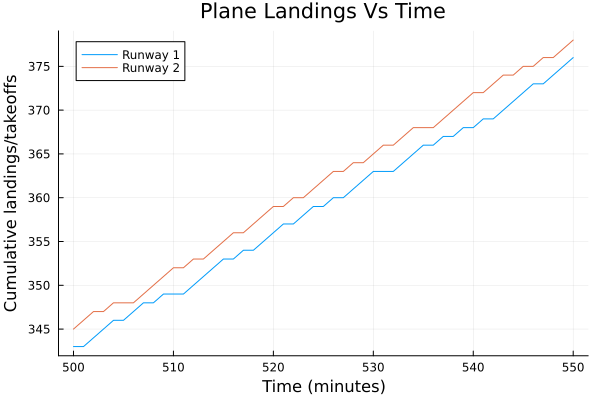

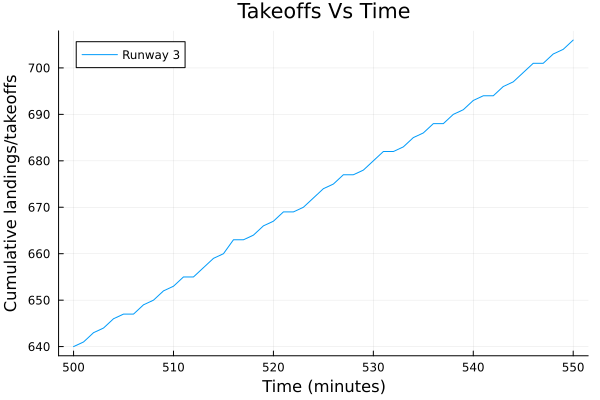

In [64]:
LB = 500;
UB = 550;

y_runway_1 = cumulative_count[1,LB:UB, 1];
y_runway_2 = cumulative_count[1,LB:UB, 2];
y_runway_3 = cumulative_count[1,LB:UB, 3];


p1 = plot(LB:UB, y_runway_1, label="Runway 1", xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs", title="Plane Landings Vs Time")
plot!(p1,LB:UB, y_runway_2, label="Runway 2")

p2 = plot(LB:UB, y_runway_3, label="Runway 3", xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs", title="Takeoffs Vs Time")

display(p1)
display(p2)


### Plotting the Monte Carlo trends for 5 days

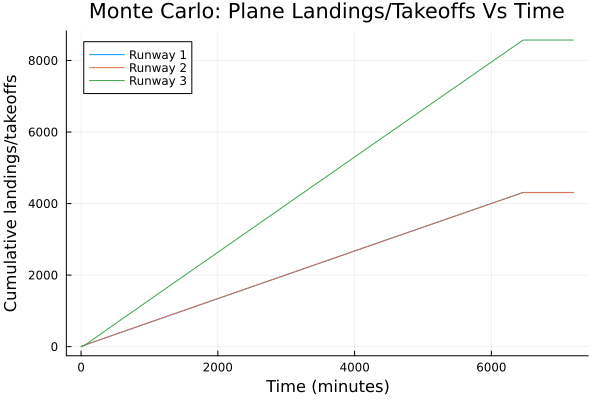

In [57]:
plot(1:7200, plane_tracker[:,1], label="Runway 1", xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs",title="Monte Carlo: Plane Landings/Takeoffs Vs Time")
plot!(1:7200, plane_tracker[:,2], label="Runway 2")
plot!(1:7200, plane_tracker[:,3], label="Runway 3")

### Plotting the Monte Carlo trends for the duration to land 8621 aircrafts

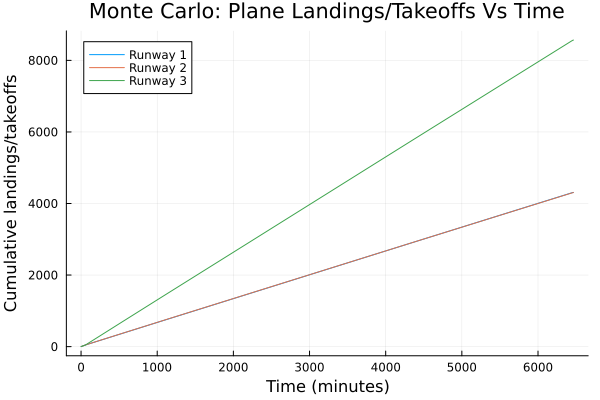

In [68]:
y_runway_1 = plane_tracker[1:xmax, 1];
y_runway_2 = plane_tracker[1:xmax, 2];
y_runway_3 = plane_tracker[1:xmax, 3];

plot(1:xmax, y_runway_1, label="Runway 1", xlabel="Time (minutes)", ylabel="Cumulative landings/takeoffs",title="Monte Carlo: Plane Landings/Takeoffs Vs Time")
plot!(1:xmax, y_runway_2, label="Runway 2")
plot!(1:xmax, y_runway_3, label="Runway 3")

---

### Load in Wind Speed Data
This has the wind speeds at Newark for every 3 minutes of the month of August in 2023. This will be used to tell us how much to delay flights by given the wind speed. Based on our background research, if the wind speed is between 30mph and 40pmh, the aircraft will be delayed by 30 minutes after the latest instance of winds in that speed. If the wind speed is greater than 40mph, the aircraft will be delayed by 1 hour from the latest instance of that wind speed. If the wind speed is under 30mph it is clear for takeoff.

In [59]:
# Load the CSV file into a DataFrame
Wind_DataFrame = DataFrame(CSV.File("Wind_Data.csv"));

# Extract wind speed and date columns
wind_speed = Wind_DataFrame."Wind Speed (mph)";
date_string = Wind_DataFrame."Date";

# Parse the date string with the correct format
date_value = Dates.DateTime.(date_string, "mm/dd/yyyy HH:MM");